In [0]:
% matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras
import math
import PIL.Image
import time
import os

from __future__ import print_function
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras import backend as K

from keras.applications import vgg16
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import save_img
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image

Using TensorFlow backend.


## MNIST

In [0]:
### Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.
def plot_images(images, cls_true):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((28, 28)), cmap='binary')

        # Show true classes.      
        xlabel = "True: {0}".format(cls_true[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

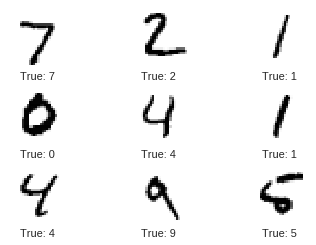

In [0]:
# Get the first images from the test-set.
images = x_test[0:9]

# Get the true classes for those images.
cls_true = y_test[0:9]


# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)


In [0]:
batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28
input_shape = (28,28,1)

In [0]:
x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Start construction of the Keras Sequential model.
model = Sequential()

# First convolutional layer with ReLU-activation and max-pooling.
model.add(keras.layers.Conv2D(filters = 32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape= input_shape, use_bias = True, name = 'layer_conv1'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(keras.layers.Conv2D(kernel_size=(3, 3), filters=64, padding='same',
                 activation='relu', name='layer_conv2', use_bias = True))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2))
model.add(keras.layers.Flatten())

# Two fully connected layers
model.add(keras.layers.Dense(128, activation='relu', use_bias = True, name = 'fc_layer1'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(num_classes, name = 'fc_layer2'))
model.add(keras.layers.Softmax())
          

model.compile(loss='categorical_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'])



In [0]:

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs)

score = model.evaluate(x_test, y_test, verbose=0)
print(score)

Epoch 1/12
60000/60000 [==============================] - 6s 101us/step - loss: 1.0883 - acc: 0.8861
Epoch 2/12
60000/60000 [==============================] - 6s 94us/step - loss: 0.0908 - acc: 0.9736
Epoch 3/12
60000/60000 [==============================] - 6s 94us/step - loss: 0.0627 - acc: 0.9810
Epoch 4/12
60000/60000 [==============================] - 6s 95us/step - loss: 0.0515 - acc: 0.9842
Epoch 5/12
60000/60000 [==============================] - 6s 95us/step - loss: 0.0428 - acc: 0.9871
Epoch 6/12
60000/60000 [==============================] - 6s 96us/step - loss: 0.0382 - acc: 0.9884
Epoch 7/12
60000/60000 [==============================] - 6s 96us/step - loss: 0.0333 - acc: 0.9894
Epoch 8/12
60000/60000 [==============================] - 6s 94us/step - loss: 0.0307 - acc: 0.9907
Epoch 9/12
60000/60000 [==============================] - 6s 93us/step - loss: 0.0305 - acc: 0.9904
Epoch 10/12
60000/60000 [==============================] - 6s 92us/step - loss: 0.0278 - acc: 0.991

In [0]:
# Save and reload model
path_model = 'model.keras.mnist'
model.save(path_model)
model_load = keras.models.load_model(path_model)
model_load.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
fc_layer1 (Dense)            (None, 128)               295040    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [0]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

(1, 26, 26, 32)


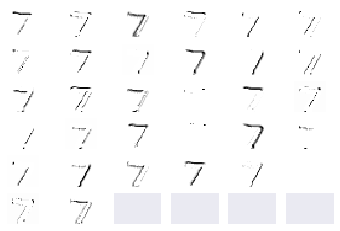

(1, 13, 13, 64)


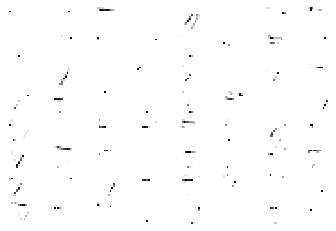

In [0]:
# get weight of filters in conv layer 1,2
layer_conv1 = model_load.layers[0]
layer_conv2 = model_load.layers[2]

# get output values of the first convolutional layer and visualize them
output_conv1 = K.function(inputs=[layer_conv1.input],
                          outputs=[layer_conv1.output])

layer_output1 = output_conv1([[x_test[0]]])[0]
print(layer_output1.shape)

plot_conv_output(values=layer_output1)

# get output values of the second convolutional layer and visualize them
output_conv2 = K.function(inputs=[layer_conv1.input],
                          outputs=[layer_conv2.output])

layer_output2 = output_conv2([[x_test[0]]])[0]
print(layer_output2.shape)
plot_conv_output(values=layer_output2)